# Try a Deep Convolutional Generative Adversarial Network on DDSM Dataset

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable
from PIL import Image

import itertools


In [2]:
# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


# Hyperparameters

In [3]:
# Root directory for dataset
labelroot='/clio/users/olgakr/DDSM/new_labels/2class/'
dataroot= '/clio/users/olgakr/DDSM/ddsm_patches/'
dataroot2='./augmented_train_masks/'

dataroot3='./augmented_val_masks/'
dataroot4='./augmented_test_masks/'
# Number of workers for dataloader
num_workers = 16

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 256

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 1

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,2,3"

In [4]:
# Decide which device we want to run on
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Load the data & create a DataLoader

In [5]:
class DDSM(torch.utils.data.Dataset):             # Notice that masks are in PNG form and mammograms in JPG
    def __init__(self, root1, root2, root3, split, transform, transform2):
        self.root1 = root1
        self.root2 = root2
        self.root3 = root3
        
        with open(os.path.join(root3, '{}.txt'.format(split)), 'r') as f:
            for line in f:
                if 'normal' in line:
                    self.image_list = (list(map(self.process_line, f.readlines())))
        
                    
        self.mask_list = os.listdir(root2)           
        self.transform = transform
        self.transform2 = transform2
        
          
    def process_line(self,line):
        if 'normal' in line:
            image_name, label = line.strip().split(' ')
            label = int(label)
            #print(image_name)
            return image_name, label  
          
    def createpatch(self, mydata, masks):  # it goes picture by picture not batch
        real = Variable(mydata.data.clone())
       
        mask = Variable(masks.data.clone())
        realdata = real[:batch_size]
        maskdata = mask[:batch_size]

        ## find the mask location
        maskpos = np.where(maskdata==1)
      
        #create index file
        indices = np.empty((maskpos[0].shape[0], len(maskpos)))
        for i in range(maskpos[0].shape[0]):

            indices[i] = np.array((maskpos[0][i],maskpos[1][i],maskpos[2][i]))



        #Get the min max index for rows and columns of all images and obtain the biggest sizes
        #print(indices[1])


        # transform real images to have a noise input

        for index in indices:
            realdata[int(index[0])][int(index[1])][int(index[2])] = np.random.uniform(-1,1)


        
        new_rows = maskpos[1]
        new_columns = maskpos[2]
        
        #size_list = [max(new_rows)-min(new_rows),max(new_columns)-min(new_columns)]
        
        
        index_list = [min(new_rows, default=0), max(new_rows, default=0),min(new_columns, default=0), 
                      max(new_columns, default=0)]
       
        
        #print(index_list)

        realdata2 = np.copy(realdata)

        
        for j in range(index_list[0],index_list[1]+1):
            for k in range(index_list[2],index_list[3]+1):
                realdata2[:, j, k] = np.random.uniform(-1,1)
        

        realdata2 = torch.from_numpy(realdata2)


        ##### Binary masks ##########
        # Find the boundaries

        realdata3 = np.copy(realdata)

        for j in range(index_list[0],index_list[1]+1):
            for k in range(index_list[2],index_list[3]+1):
                realdata3[:, j, k] = 1




        realdata3 = torch.from_numpy(realdata3)

        np.place(realdata3.numpy(),realdata3.numpy()<1, [0])

            ###########################

        # Realdata have the noise input in mask shape, realdata2 contain a rectangle bounding box, realdata3 is the binary 
        # rectangle shaped mask 0 outside the rectangle box and 1s inside

        return realdata, realdata2, realdata3 


    def __len__(self):
        #print(len(self.image_list))
        #print(len(self.mask_list))
        
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name,label = self.image_list[idx]

        image = Image.open(os.path.join(self.root1, image_name)).convert("L")
        image = self.transform(image)
        
        mask_name = self.mask_list[idx]
        mask = Image.open(os.path.join(self.root2,mask_name)).convert("L")
    
        mask = self.transform2(mask) 
        
        np.place(mask.numpy(),mask.numpy()>0, [1])
        
        
        inputmask, inputbox, binarymask = self.createpatch(image, mask)
        
        return image, mask, inputmask, inputbox, binarymask

    

transform = transforms.Compose([
                
                transforms.Resize([256,256]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])])

transform2 = transforms.Compose([
             
                transforms.Resize([256,256]),
                transforms.ToTensor()])

train_dataset = DDSM(dataroot, dataroot2, labelroot, 'train', transform=transform, transform2 = transform2)



train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True)

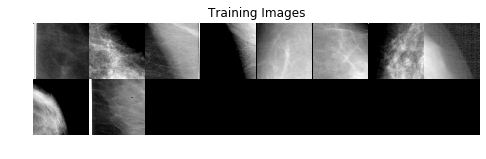

In [6]:
# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
real_batch[0].shape # G and D should generate and be fed with 28x28 images!!

torch.Size([64, 1, 256, 256])

In [8]:
mask_patch = real_batch[1]

print(torch.min(mask_patch))
print(torch.max(mask_patch))

tensor(0.)
tensor(1.)


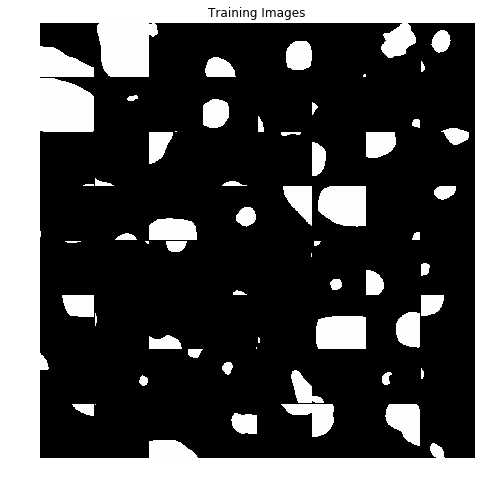

In [9]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(mask_patch.to(device), padding=2, normalize=True).cpu(),(1,2,0)))

#  Weight initialization for both Generator and Discriminator

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Class Adversarial AutoEncoder Generator

In [7]:
# Generator Code

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        #input 1x256x256
        self.conv1 = nn.Conv2d(2, ngf, 3, 1, 1, bias=False) # one channel for the image one for the mask
        self.bn1 = nn.BatchNorm2d(ngf)
        #first layer ngf x 256 x 256
        self.conv2 = nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False)  # second layer will be concatenated (remember x and y)
        self.bn2 = nn.BatchNorm2d(ngf * 2)
        #second layer ngf*2 x 128 x 128
        self.conv3 = nn.Conv2d(ngf * 2, ngf * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf * 4)
        #second layer ngf*2 x 64 x 64
        self.conv4 = nn.Conv2d(ngf * 4, ngf * 8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf * 8) 
        #second layer ngf*2 x 32 x 32
        self.conv5 = nn.Conv2d(ngf * 8, ngf * 16, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(ngf * 16)
        #third layer ngf*4 x 16 x 16
        self.conv6 =  nn.Conv2d( ngf * 16, ngf * 32, 4, 2, 1, bias=False)
        self.bn6 = nn.BatchNorm2d(ngf * 32)
        #forth layer ngf*8 x 8 x 8
        self.conv7 =  nn.Conv2d( ngf * 32, ngf * 64, 4, 2, 1, bias=False)
        
        #fifth layer ngf*16 x 4 x 4
            
    def forward(self, input, masking):
        x = torch.cat([input, masking], 1)
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        #print('1: ', x.shape)
        x = F.leaky_relu(self.bn2(self.conv2(x)),0.2)
        #print('2: ', x.shape)
        x = F.leaky_relu(self.bn3(self.conv3(x)),0.2)
        #print('3: ', x.shape)
        x = F.leaky_relu(self.bn4(self.conv4(x)),0.2)
        #print('4: ', x.shape)
        x = F.leaky_relu(self.bn5(self.conv5(x)),0.2)
        #print('5: ', x.shape)
        x = F.leaky_relu(self.bn6(self.conv6(x)),0.2)
        #print('6: ', x.shape)
        x = torch.tanh(self.conv7(x))
        #print('7: ', x.shape)
        return x
            
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.dec1 = nn.ConvTranspose2d(ngf * 64, ngf * 32, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf*32)
        #1st layer ngf*32  x 8 x 8
        self.dec2 = nn.ConvTranspose2d(ngf * 32, ngf * 16, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf*16)
        #1st layer ngf*16  x 16 x 16
        self.dec3 = nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf*8)
        #3st layer ngf* 8 x 32 x 32
        self.dec4 = nn.ConvTranspose2d(ngf*8, ngf * 4, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf*4)
        #4nd layer ngf*4 x 64 x 64
        self.dec5 = nn.ConvTranspose2d(ngf*4, ngf * 2, 4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(ngf*2)
        #5rd ngf*2 x 128 x 128
        self.dec6 = nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False)
        self.bn6 = nn.BatchNorm2d(ngf)
        #6th layer ngf x 256 x 256
        self.dec7 = nn.ConvTranspose2d(ngf, nc, 3, 1, 1, bias=False)
        #7th layer 1 x 256 x 256
     
    def forward(self, input):
        x = F.relu(self.bn1(self.dec1(input)))
        #print('1: ', x.shape)
        x = F.relu(self.bn2(self.dec2(x)))
        #print('2: ', x.shape)
        x = F.relu(self.bn3(self.dec3(x)))
        #print('3: ', x.shape)
        x = F.relu(self.bn4(self.dec4(x)))
        #print('4: ', x.shape)
        x = F.relu(self.bn5(self.dec5(x)))
        #print('5: ', x.shape)
        x = F.relu(self.bn6(self.dec6(x)))
        #print('6: ', x.shape)
        x = torch.tanh(self.dec7(x))
        #print('7: ', x.shape)

        return x

In [8]:
encoder = Encoder()
encoder = encoder.to(device)


encoder.apply(weights_init)

# Handle multi-gpu if desired
if (device.type == 'cuda') and ngpu > 1:
#     encoder = nn.DataParallel(encoder, list(range(ngpu))) ### ti einai auto pou kaneis edw de katalava..!
    encoder = nn.DataParallel(encoder)
    
print(encoder.module)

Encoder(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  

/home/olgakra/anaconda3/envs/myenv/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:25: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [9]:
# Create the decoder
decoder = Decoder()
decoder = decoder.to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
decoder.apply(weights_init)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    decoder = nn.DataParallel(decoder)


# Print the model
print(decoder.module)

Decoder(
  (dec1): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec6): ConvTranspose2d(64, 32, kernel_siz

# Class Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
  
        self.main = nn.Sequential(
            # input is (nc) x 256 x 256   
            nn.Conv2d(nc, ndf , 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf ) x 128 x 128
            nn.Conv2d(ndf , ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf * 2) x 64 x 64
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf * 4) x 32 x 32
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf * 8) x 16 x 16
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            #state size (ndf * 16) x 8 x 8
            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf * 32) x 4 x 4
            nn.Conv2d(ndf * 32, 1, 4, 1, 0, bias=False),  
            nn.Sigmoid()
            # prob (0,1)
        )

    def forward(self, input):
        return self.main(input)

    
    
    

        

In [11]:
# Create the Discriminator
netD = Discriminator()
netD = netD.to(device)


# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD) 

# Print the model
print(netD.module)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=Tr

In [12]:
adversarial_loss = torch.nn.BCELoss()
pixelwise_loss = torch.nn.L1Loss()


In [13]:
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr, betas=(beta1, 0.999))

In [ ]:
fixed_noise = real_batch[3].to(device)


real_label = 1
fake_label = 0
fake_labels = torch.zeros(batch_size, 1)


label = torch.FloatTensor(batch_size).to(device)

In [ ]:


# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data) in enumerate(train_loader,0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
    
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        
        mask_cpu = data[1].to(device)
       
        
        #print('real:',real_cpu.shape)  # shape of the image tensor
        b_size = real_cpu.size(0)
        
        noise = data[3].to(device)
        
        
       
       
        
        label = torch.full((b_size,), real_label).to(device)
        #print('label shape:', label.shape)  # shape of the real label tensor
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1) 
        #print(output)
          
        #print('output shape:', output.shape) # shape of the generated label tensor
        # Calculate loss on all-real batch
        errD_real = adversarial_loss(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()  # the output of real images has to be close to 1 (prob for real close to 1)

        
        
        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        
        # Generate fake image batch with G
        
       
        
        encoded_imgs = encoder(noise.float(),mask_cpu.float())
        fake = decoder(encoded_imgs)
        
        
        #print('fake:',fake.shape)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        #print(label.shape)
        #print(output.shape)
        # Calculate D's loss on the all-fake batch
        errD_fake = adversarial_loss(output, label)  ### Label = 0 since it's fake, if D is good output should also be around 0
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()   # the output of fake images has to be close to 0 (prob for fake close to 0)
        
        # Add the gradients from the all-real and all-fake batches
        errD = 0.5 * (errD_real + errD_fake)  ## a high score means a good discriminator (look on the DmaxGmin equation)
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        encoder.zero_grad()
        decoder.zero_grad()
        
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = 0.001* (adversarial_loss(output, label)) + 0.999 * (pixelwise_loss(fake, real_cpu))
        
        # Calculate gradients for G
        #reset_grad() do I need this?
        errG.backward()
        D_G_z2 = output.mean().item()  
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on generated images
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                encoded_imgs = encoder(fixed_noise.float(), mask_patch.to(device).float())
                fake = decoder(encoded_imgs)
            img_list.append(vutils.make_grid(fake.detach().cpu(), padding=2, normalize=True))

        iters += 1



<Figure size 720x360 with 0 Axes>

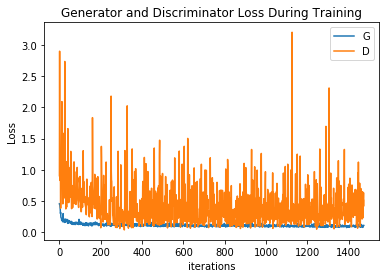

In [20]:
plt.figure(figsize=(10,5))
fig = plt.figure()
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
#fig.savefig('Losses-patch.png')

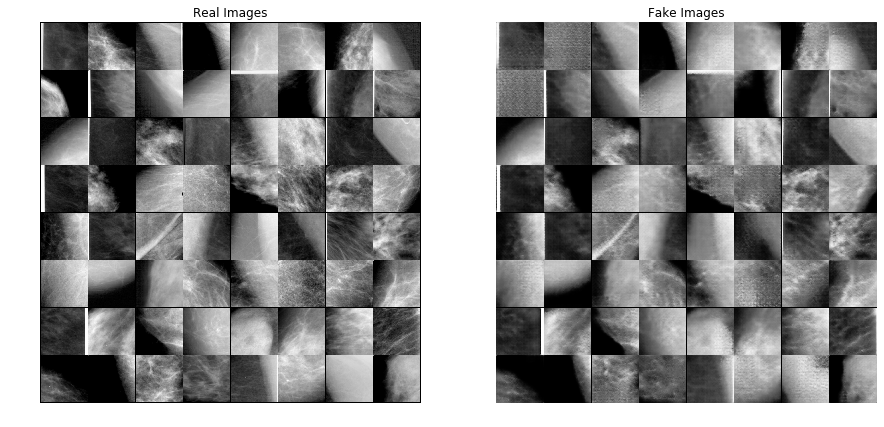

In [21]:

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))  
plt.show()

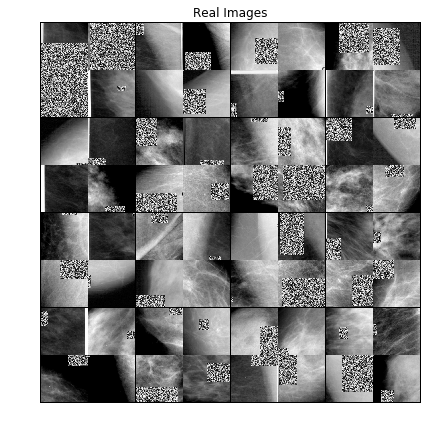

In [22]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(fixed_noise.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

In [23]:
encoder.eval()


DataParallel(
  (module): Encoder(
    (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv6): Conv2d(512, 1024, kernel_size=(4, 4

In [24]:
decoder.eval()

DataParallel(
  (module): Decoder(
    (dec1): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [25]:
test_dataset = DDSM(dataroot, dataroot4, labelroot, 'test',  transform=transform, transform2=transform2)



test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True)

In [26]:
test_batch = next(iter(test_loader))

In [27]:

test_noise = test_batch[3].to(device)

In [28]:
encoded_imgs = encoder(test_noise.float(), test_batch[1].to(device).float())
fakes = decoder(encoded_imgs)


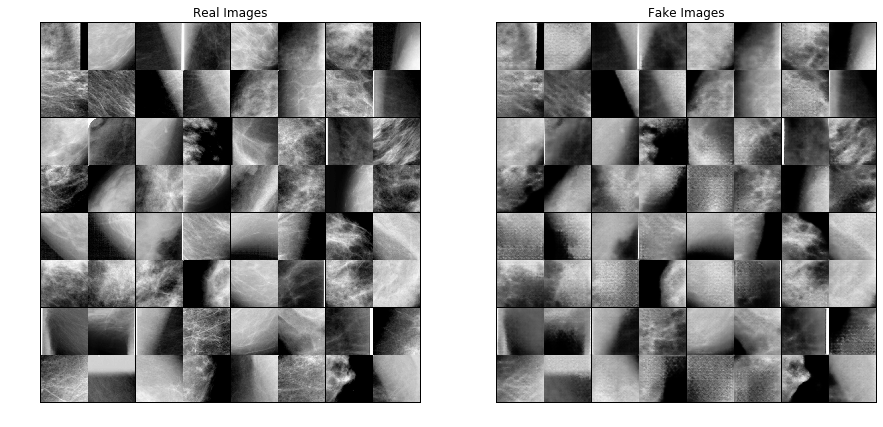

In [29]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(test_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fakes.detach().to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

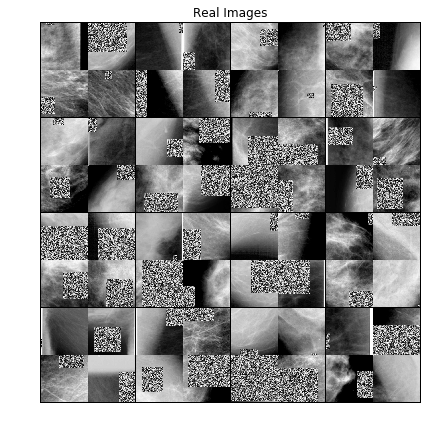

In [30]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(test_noise.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Load and do evaluation on the trained on 50 epochs model

In [14]:
path= './saved_models/model-DCGAN-BC-AdversarialEncDec-patch-MaskInfilling-BCMasks-2chan-Box-Mask-256/'

In [15]:
encoder.load_state_dict(torch.load(path + 'encoder-patch-AE-50e.pth'))
decoder.load_state_dict(torch.load(path + 'decoder-patch-AE-50e.pth'))

netD.load_state_dict(torch.load(path + 'netD-patch-AE-50e.pth'))

In [16]:
encoder.eval()

DataParallel(
  (module): Encoder(
    (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv6): Conv2d(512, 1024, kernel_size=(4, 4

In [17]:
decoder.eval()

DataParallel(
  (module): Decoder(
    (dec1): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [18]:
test_dataset = DDSM(dataroot, dataroot3, labelroot, 'val',  transform=transform, transform2 = transform2)



test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True)

In [19]:
test_batch = next(iter(test_loader))


In [20]:
test_noise = test_batch[3].to(device)


In [21]:
encoded_imgs = encoder(test_noise.float(), test_batch[1].float())
fakes = decoder(encoded_imgs)


In [22]:
fakes.shape

torch.Size([64, 1, 256, 256])

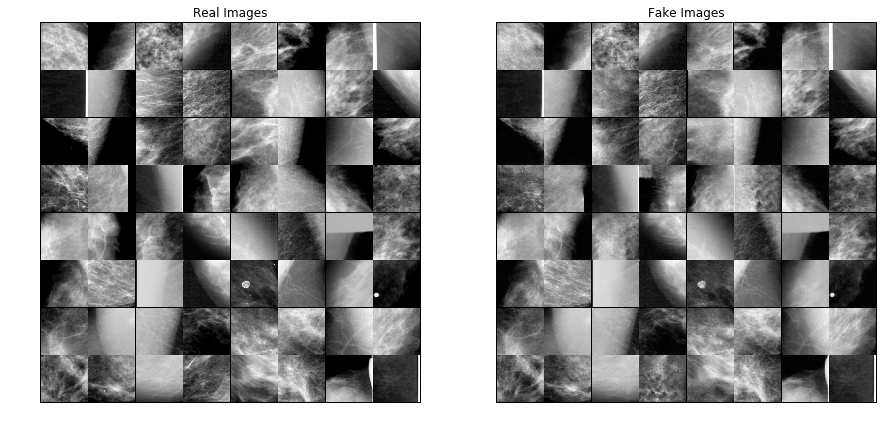

In [23]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(test_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fakes.detach().to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

In [24]:
#vutils.save_image(test_batch[0].to(device)[:64], 'real.png', padding=5, normalize=True)

In [25]:
#vutils.save_image(fakes.detach().to(device)[:64], 'fake.png', padding=5, normalize=True)

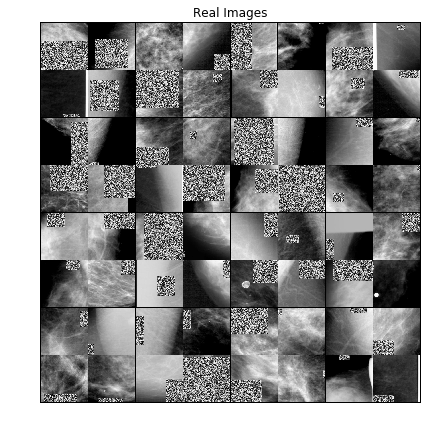

In [26]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(test_noise.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Save generated & Real images

In [32]:
#for i in range(fakes.shape[0]):

    #vutils.save_image(fakes[i,:,:,:], os.path.join('./generated_images/','{}.png'.format(i)), padding=5, normalize=True)
    

In [33]:
#for i in range(test_batch[0].shape[0]):

    #vutils.save_image(test_batch[0][i,:,:,:], os.path.join('./real_images/','{}.png'.format(i)), padding=5, normalize=True)
    

In [34]:
cou = 0
for j,data in enumerate(test_loader,0):
        real_cpu = data[0].to(device)
        for i in range(batch_size):
            try:
      
                vutils.save_image(real_cpu[i,:,:,:], os.path.join('./real_images/','{}.png'.format(cou)), padding=5, normalize=True)
                cou = cou + 1


            except:
                print('The last batch is smaller so I ignored the error')
                pass


            
# Ignore the error, it is because the last batch is smaller than 64 images

The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is sm

In [35]:
count = 0 
with torch.no_grad():
    for j, (data) in enumerate(test_loader, 0 ):

    
        
        # Format batch
        real_cpu = data[0].to(device)
        
        
        
        masks = data[1].to(device)
        
        noise = data[3].to(device)
        noise = noise.to(device)
        
        encoded_imgs = encoder(noise.float(), masks.float())
        fake = decoder(encoded_imgs)
        for i in range(batch_size):
            try:
                vutils.save_image(fake[i,:,:,:], os.path.join('./generated_images/','{}.png'.format(count)), padding=5, normalize=True)
                count = count + 1
                
            except:
                print('The last batch is smaller so I ignored the error')
                pass

The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is smaller so I ignored the error
The last batch is sm